### DESC Hack Day: 2017 Winter Meeting

### Supernova Cosmology Inference with Probabilistic Photometric Redshifts 

Tina Peters, Alex Malz, Anita, Humna, Kara

From Confluence: We're planning to hack on a method for making a Hubble diagram using photo-z PDFs rather than point estimators. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
repoDir= os.getcwd()
os.chdir(os.path.join( repoDir, '..' ))
repoDir= os.getcwd()
from astropy.io import ascii

Create a true catalog of N objects. 

- Know z-dist, type-dist. 
    - Done: N(z) based on Behroozi; SNType distribution from Kara.
- Sample to get z-true and type-true.
    - Same using MC. Seed hard coded. 1000 iterations.
- Calculate mu_s based on z-true, H0-true.

--

Observed catalogs: prob(z-obs, type-obs, mu-obs | data)



In [2]:
def MC(Nrand, probs): 
    # returns probabilities after an MC run
    np.random.seed(10)
    randNs= np.random.random(Nrand)
    
    counts= np.zeros(len(probs))
    probs= [0]+list(probs)
    cumProbs= np.cumsum(probs)
    for randN in randNs:   
        for i in np.arange(1,len(probs)):
            if (randN> cumProbs[i-1]) and (randN<=cumProbs[i]):
                counts[i-1]+=1    
    return counts/Nrand

In [3]:
dataDir= repoDir+'/relative_sne/'
SNdata= ascii.read(dataDir+'relative_rates.txt')   # data from Kara P.
os.chdir(repoDir)
SNdata_zBin= SNdata['redshift']

In [4]:
def probTypes(): # assumes SNData is in the shell 
    SNdata_Ia= SNdata['SN_Ia']
    SNdata_Ibc= SNdata['SN_Ibc']
    SNdata_II= SNdata['SN_II']
    
    probs= np.zeros(shape=(len(SNdata_Ia), 3))
    for i in range(len(SNdata_Ia)):
        probs[i]= MC(1000, [SNdata_Ia[i], SNdata_Ibc[i], SNdata_II[i]])
    
    return probs

In [5]:
 def probZbin(zBins):  # assume SNdata_zBin is in the shell.
    # returns the redshift probability dist (+zBin array)
    
    def unnormNz(zBins):
        z0 = 1.243
        A = -0.997
        B = 0.241
        C = 0.180
        return C/(10.**(A*(zBins-z0)) + 10.**(B*(zBins-z0)))*(1./0.7)
    
    def normNz(zBins):
        unnorm= unnormNz(zBins)
        normConstant= np.dot(zBins,unnorm)
        return unnorm/normConstant
        
    probs= MC(1000, normNz(zBins[1:]))
    return probs #[probs, zBins]

In [6]:
def mu(H0, z, Om0=0.3):  
    # defined function: distance modulus
    # assume flat universe
    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3)
    dL= cosmo.luminosity_distance(z)  
    
    return 5*np.log10(dL.value)+25

In [7]:
# find true redshifts
NTotObjs= 500
zTrue= np.zeros(NTotObjs)
trueType= np.zeros(NTotObjs)

zBins= SNdata_zBin
probZ= probZbin(zBins)
probZ= [0]+list(probZ)
cumProbZ= np.cumsum(probZ)

randNs= np.random.random(NTotObjs)

zInd= np.zeros(NTotObjs)   # lower z-bin index. easiest to use to get probT later

for i in range(NTotObjs):
    for j in np.arange(1,len(cumProbZ)):
        if (randNs[i]> cumProbZ[j-1]) and (randNs[i]<=cumProbZ[j]):
            zInd[i]= j-1
            zTrue[i]= np.random.uniform(low=zBins[j-1], high=zBins[j]) #np.mean([zBins[j-1],zBins[j]])

In [8]:
# find true types given true redshifts
randNs= np.random.random(NTotObjs)
probT= probTypes()
           
for i in range(len(zTrue)):
    probTz= [0]+list(probT[zInd[i]])
    cumProbTz= np.cumsum(probTz)
    
    #print cumProbTz
    for j in np.arange(1,len(cumProbTz)):
        if (randNs[i]> cumProbTz[j-1]) and (randNs[i]<=cumProbTz[j]):
            trueType[i]= j

/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


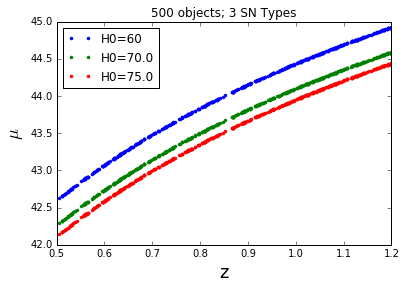

In [9]:
H0s= [60, 70., 75.]
fontsize= 18
for H0 in H0s:
    muTrue= mu(H0= H0, z= zTrue, Om0=0.3)
    plt.plot(zTrue, muTrue, '.', label= 'H0=%s'%H0)
plt.title('%s objects; 3 SN Types'%NTotObjs)
plt.xlabel('z', fontsize= fontsize)
plt.ylabel('$\mu$', fontsize= fontsize)
plt.legend(loc= "best")

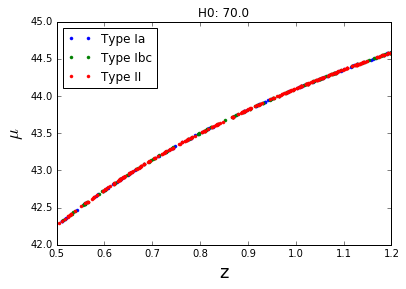

In [10]:
H0= 70.
fontsize= 18

muTrue= mu(H0= H0, z= zTrue, Om0=0.3)
labels= {1: 'Type Ia', 2: 'Type Ibc', 3: 'Type II'}
for typeNum in [1., 2., 3.]:
    ind= np.where(trueType==typeNum)[0]

    plt.plot(zTrue[ind], muTrue[ind], '.', label= '%s'%labels[typeNum])

plt.title('H0: %s'%H0)
plt.xlabel('z', fontsize= fontsize)
plt.ylabel('$\mu$', fontsize= fontsize)
plt.legend(loc= "best")

### Scramble the data to create a mock 'observed' catalog.

$P(\mu, z, T|\ell, f, \theta^*, \Phi^*)=  P(\ell, f| \mu, z, T) P(\mu|\theta^*) P(z, T|\Phi^*)$

We take $\theta^*= H_0$, so $ P(\mu|\theta^*)= 1$

Here we dont have a joint probability distribution of redshift and SN type. Instead, we have

$P(z, T|\Phi^*)= P(z|T,N(z)) \ P(T)$

where $F(T)$ is based on SN fractions from Kara.

In [11]:
def hyper_probTypes(zBins): # assumed prob dist of SN types as a function of z.
    # assume SNdata_zBin is in the shell.
    totEntries= len(zBins)
    SNdata_Ia= np.zeros(totEntries) + 1/3.
    SNdata_Ibc= np.zeros(totEntries) + 1/3.
    SNdata_II= np.zeros(totEntries) + 1/3.
    
    probs= np.zeros(shape=(len(SNdata_Ia), 3))
    for i in range(len(SNdata_Ia)):
        probs[i]= MC(1000, [SNdata_Ia[i], SNdata_Ibc[i], SNdata_II[i]])
    
    return probs

In [12]:
def hyper_probZbin(zBins):  # assume SNdata_zBin is in the shell.
# returns the redshift probability dist (+zBin array)

    def unnormNz(zBins):
        return np.zeros(len(zBins))+1.   # same N in each zBin
    def normNz(zBins):
        unnorm= unnormNz(zBins)
        normConstant= np.dot(zBins,unnorm)
        return unnorm/normConstant

    probs= MC(1000, normNz(zBins))
    return probs

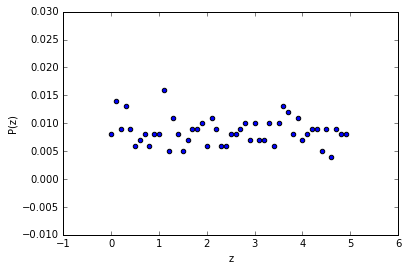

In [13]:
zBins= np.arange(0,5, 0.1)
plt.scatter(zBins, hyper_probZbin(zBins)) #, bins= zBins)

plt.xlabel('z')
plt.ylabel('P(z)')

In [14]:
hyper_probTypes(zBins)[0]

array([ 0.357,  0.311,  0.332])

In [15]:
# find true redshifts
zPrime= np.zeros(NTotObjs)
TPrime= np.zeros(NTotObjs)

zBins= SNdata_zBin
hyper_probZ= hyper_probZbin(zBins)
hyper_probZ= [0]+list(hyper_probZ)
hyper_cumProbZ= np.cumsum(hyper_probZ)

randNs= np.random.random(NTotObjs)

zIndPrime= np.zeros(NTotObjs)   # lower z-bin index. easiest to use to get probT later

for i in range(NTotObjs):
    for j in np.arange(1,len(hyper_cumProbZ)):
        if (randNs[i]> hyper_cumProbZ[j-1]) and (randNs[i]<=hyper_cumProbZ[j]):
            zIndPrime[i]= j-1
            zPrime[i]= np.random.uniform(low=zBins[j-1], high=zBins[j]) #np.mean([zBins[j-1],zBins[j]])

In [16]:
uPrime= mu(H0, zPrime, Om0=0.3)

$P(\ell, f| \mu, z, T)= MVN(\ell, f| \mu, z, \sigma_{\mu z})D(T)$

where MVN is Multivariate gaussian dist, D is a discrete probability distribution.

In [17]:
from scipy.stats import multivariate_normal

In [18]:
cov = np.diag(np.array([1,1]))
MVN= multivariate_normal(mean=[np.mean(uPrime), np.mean(zPrime)], cov= cov) #.pdf(4)

In [19]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]

To do: add a function to sample give probs, etc.